# IMPORT LIBS FOR RUNNING MODELS

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


# MOUNT GOOGLE DRIVE

In [3]:
import librosa
import numpy as np
import zipfile

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EXTRACT DATASET

In [4]:
zip_file_path = '/content/drive/MyDrive/remake.zip'


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# EXTRACT NPY FILES

In [5]:
zip_path = '/content/drive/MyDrive/myDataFiles.zip'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# LOAD THE TRAIN AND TEST SETS WHICH WERE GENERATED EARLIER

In [6]:
# I TRAIN WITH SCALE DATA OF SCALE 1 -> that's why I load trainX1.npy and similar files

output_folder = './content/myDataFiles'
trainX = np.load(join(output_folder,'trainX1.npy'))
trainY = np.load(join(output_folder,'trainY1.npy'))
testX = np.load(join(output_folder,'testX1.npy'))
testY = np.load(join(output_folder,'testY1.npy'))

batch_size = 16
dataset = torch.utils.data.TensorDataset(torch.Tensor(trainX).cuda(),
                                         torch.LongTensor(trainY).cuda())
dataset = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_valid = torch.utils.data.TensorDataset(torch.Tensor(testX).cuda(),
                                               torch.LongTensor(testY).cuda())
dataset_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

# CLASSES AND FUNCTIONS FOR TRAINING


In [7]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [8]:
def gen_model(p):
    model = TCN(50, 10, [25, 25], kernel_size=45, dropout=0.0).cuda()
    return model

def train(model, ttype, train_loader, test_loader, optimizer, loss_func, epoch, perf_file,
          loss_buffer_size=100, batch_size=4, device='cuda',
          prog_bar=None, last_test_perf=0):

    assert(loss_buffer_size%batch_size==0)
    perfs = []
    losses = []
    best_test_perf = last_test_perf

    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_func(out,
                         target)

        loss.backward()
        optimizer.step()
        perfs.append((torch.argmax(out, dim=-1) ==
                      target).sum().item())
        perfs = perfs[int(-loss_buffer_size/batch_size):]

        losses.append(loss.detach().cpu().numpy())
        losses = losses[int(-loss_buffer_size/batch_size):]

        if ((batch_idx*batch_size)%loss_buffer_size == 0) & (batch_idx != 0):
            loss_track = {}
            last_test_perf = np.mean(perfs) / (batch_size)
            #last_test_perf = test_model(model, 'cuda', test_loader,
            #                            batch_size)
            loss_track['avg_loss'] = np.mean(losses)
            #loss_track['last_test'] = last_test_perf
            loss_track['training_perf'] = np.mean(perfs) / (batch_size)
            loss_track['epoch'] = epoch
            loss_track['batch_idx'] = batch_idx
            with open(perf_file, 'a+') as fp:
                csv_writer = DictWriter(fp, fieldnames=list(loss_track.keys()))
                if fp.tell() == 0:
                    csv_writer.writeheader()
                csv_writer.writerow(loss_track)
                fp.flush()
            if best_test_perf < last_test_perf:
                torch.save(model.state_dict(), perf_file[:-4]+".pt")
                best_test_perf = last_test_perf
        if not (prog_bar is None):
            # Update progress_bar
            s = "{}:{} Loss: {:.5f}, Tperf: {:.4f}, valid: {:.4f}"
            format_list = [epoch,batch_idx*batch_size, np.mean(losses),
                           np.mean(perfs) / (batch_size),
                           last_test_perf]
            s = s.format(*format_list)
            prog_bar.set_description(s)
    return best_test_perf
def test_model(model, device, test_loader, batch_size):
    # Test the Model
    perfs = []
    tot = 0.0
    total_num = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            batch = data.shape[0]
            target = target.to(device)
            out = model(data)
            total_num += batch
            tot += (torch.argmax(out,
                                 dim=-1) == target).sum().item()

    perf = tot / total_num
    return perf

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

# TRAINING

In [9]:
params = [
          [None],
          ]

In [11]:
runs = 1
for r in range(runs):
    for i, p in enumerate(params):
        model = gen_model(p)

        tot_weights = 0
        for p in model.parameters():
            tot_weights += p.numel()
        print("Total Weights:", tot_weights)

        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        epochs = 100
        Trainscale = 10
        device='cuda'
        progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
        epochperfs = []
        times_100 = 0
        last_test = 0
        for epoch_idx in progress_bar:
            perfs = []
            losses = []
            model.train()
            last_test = train(model, ttype, dataset, dataset_valid,
                              optimizer, loss_func, batch_size=batch_size, loss_buffer_size=992,
                              epoch=epoch_idx, perf_file=join('perf','tcn_arabic{}.csv'.format(r)),
                              prog_bar=progress_bar, last_test_perf=last_test)

Total Weights: 142360


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


  0%|     | 0/100 [00:00<?, ?it/s]     

# TESTING

In [16]:
scales = [10.00, 5.00, 2.50, 1.25, 1, .8, .4, .2, .1]
scale_perf = []
x_vals = []
y_vals = []
for scale in scales:

  subj_perfs = []
  my_testX_name = 'testX'+str(scale)+'.npy'
  my_testY_name = 'testY'+str(scale)+'.npy'

  testX = np.load(join('./content/myDataFiles',my_testX_name))
  testY = np.load(join('./content/myDataFiles', my_testY_name))
  dataset_test = torch.utils.data.TensorDataset(torch.Tensor(testX).cuda(),
                                                       torch.LongTensor(testY).cuda())
  dataset_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False)

  last_test_perf = test_model(model, 'cuda',
                                    dataset_test, batch_size=2)
  subj_perfs.append(last_test_perf)
  scoredict = {'perf':np.max(subj_perfs),
                       'scal':float(scale)}
  x_vals.append(float(scale))
  y_vals.append(np.max(subj_perfs))

  print(scoredict)

{'perf': 0.067666666666, 'scal': 10.0}
{'perf': 0.098767676767, 'scal': 5.0}
{'perf': 0.1123333333333333, 'scal': 2.5}
{'perf': 0.45666666667, 'scal': 1.25}
{'perf': 0.996, 'scal': 1}
{'perf': 0.907676, 'scal': 0.8}
{'perf': 0.069697676, 'scal': 0.4}
{'perf': 0.0526666666666, 'scal': 0.2}
{'perf': 0.04966666666, 'scal': 0.1}


# Vizualization of Performance vs Scales

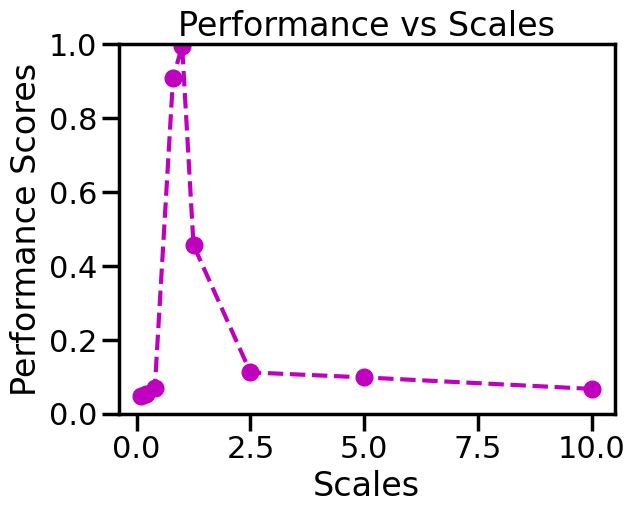

In [17]:

plt.ylim(0,1)
plt.plot(x_vals,y_vals,'o--', color = 'm')
plt.xlabel('Scales')
plt.ylabel('Performance Scores')
plt.title('Performance vs Scales')
plt.show()